# Przetwarzanie oraz filtrowanie danych

Poniższy notebook prezentuje sposób przetwarzania danych z czujników Airly dla projektu CST

In [2]:
import pickle
import requests
import os
from datetime import date
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np
import pandas as pd
# load json containins 50 sensors around Cracow


Nasze dotychczasowe dane zebrane zostały w formie plików pickle, by móc je na obecnym poziomie rozwinięcia naszej bazy
załadować do pamięci komputera. Dane z czujników w podanych plikach zapisane są w złożonych słownikach, z których musimy
wydobyć odpowiednie dane. Na ten moment wydobywane są PM1, PM25, PM10. Również wydobywane zostaje położenie wszystkich
położeń które na ten moment zostanie użyte w procesie interpolacji brakujących danych

In [17]:
def get_sensors():
    try:
        with open('./data/50sensors.json', 'rb') as pickle_file:
            sensors_list = pickle.load(pickle_file)
    except:
        print("File /'50sensors.json/' with sensors ID-s doesn't exist.")
    return sensors_list

In [18]:
sensors_list = get_sensors()
sensors = dict()
for sensor in sensors_list:
    sensors[sensor['id']] = {'x': sensor['location']['latitude'], 'y': sensor['location']['longitude']}
sensors

{8077: {'x': 50.062006, 'y': 19.940984},
 87160: {'x': 50.064539, 'y': 19.942561},
 10211: {'x': 50.059085, 'y': 19.933919},
 58: {'x': 50.057447, 'y': 19.946008},
 86934: {'x': 50.062418, 'y': 19.928368},
 87166: {'x': 50.070088, 'y': 19.943812},
 17: {'x': 50.057678, 'y': 19.926189},
 33011: {'x': 50.059685, 'y': 19.957563},
 87164: {'x': 50.063904, 'y': 19.922548},
 8076: {'x': 50.054907, 'y': 19.956501},
 101557: {'x': 50.049168, 'y': 19.946672},
 37818: {'x': 50.066747, 'y': 19.962083},
 10043: {'x': 50.064567, 'y': 19.918564},
 38444: {'x': 50.07174, 'y': 19.962317},
 86960: {'x': 50.057242, 'y': 19.914874},
 86936: {'x': 50.079672, 'y': 19.94919},
 86908: {'x': 50.044424, 'y': 19.952205},
 39735: {'x': 50.042557, 'y': 19.940229},
 86949: {'x': 50.047736, 'y': 19.919646},
 2935: {'x': 50.072968, 'y': 19.914829},
 8165: {'x': 50.072763, 'y': 19.911081},
 10053: {'x': 50.08017, 'y': 19.918918},
 1026: {'x': 50.038499, 'y': 19.94685},
 86980: {'x': 50.043741, 'y': 19.966589},
 10039

Poniżej ukazana dystrubicja sensorów na płaszczyźnie. Już z samego położenia czujników można wywnioskować że predykcje w
mniej zaludnionych obszarach będą ograniczone większymi błędami

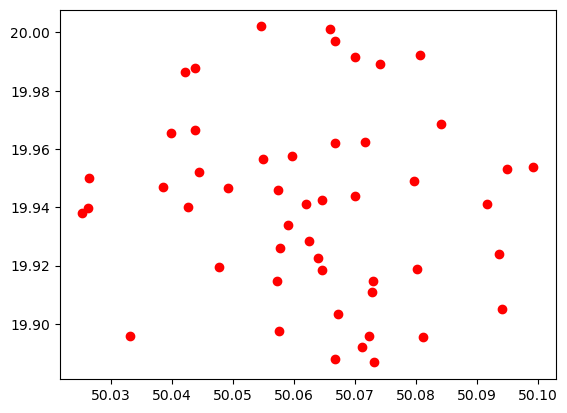

In [19]:
y = [sensors[i]['y'] for i in sensors]
x = [sensors[i]['x'] for i in sensors]
plt.scatter(x, y, color='red')
plt.show()

In [20]:
sensors_data = dict()

# iterate over files in that directory
for directory in next(os.walk('./data/'))[1]:
    temp_list = dict()
    for filename in os.listdir(f'./data/{directory}/{directory}'):
        f = os.path.join(f'./data/{directory}/{directory}', filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            with open(f, 'rb') as fp:
                temp_list[filename[:filename.find('.')]] = pickle.load(
                    fp)  # loading dayli measurements from each sensor
    sensors_data[directory] = temp_list

./data/2022-11-08/2022-11-08\10032.json
./data/2022-11-08/2022-11-08\10039.json
./data/2022-11-08/2022-11-08\10042.json
./data/2022-11-08/2022-11-08\10043.json
./data/2022-11-08/2022-11-08\10045.json
./data/2022-11-08/2022-11-08\10053.json
./data/2022-11-08/2022-11-08\101557.json
./data/2022-11-08/2022-11-08\10211.json
./data/2022-11-08/2022-11-08\1026.json
./data/2022-11-08/2022-11-08\10279.json
./data/2022-11-08/2022-11-08\17.json
./data/2022-11-08/2022-11-08\18410.json
./data/2022-11-08/2022-11-08\18489.json
./data/2022-11-08/2022-11-08\2743.json
./data/2022-11-08/2022-11-08\2935.json
./data/2022-11-08/2022-11-08\33011.json
./data/2022-11-08/2022-11-08\37818.json
./data/2022-11-08/2022-11-08\38444.json
./data/2022-11-08/2022-11-08\39577.json
./data/2022-11-08/2022-11-08\39735.json
./data/2022-11-08/2022-11-08\41210.json
./data/2022-11-08/2022-11-08\43068.json
./data/2022-11-08/2022-11-08\58.json
./data/2022-11-08/2022-11-08\60.json
./data/2022-11-08/2022-11-08\7956.json
./data/2022-

In [21]:
list(sensors_data.keys())

['2022-11-08',
 '2022-11-09',
 '2022-11-10',
 '2022-11-11',
 '2022-11-12',
 '2022-11-13',
 '2022-11-14',
 '2022-11-15',
 '2022-11-16',
 '2022-11-17',
 '2022-11-18',
 '2022-11-19',
 '2022-11-20',
 '2022-11-21',
 '2022-11-22',
 '2022-11-23',
 '2022-11-24',
 '2022-11-25',
 '2022-11-26',
 '2022-11-27',
 '2022-11-28',
 '2022-11-29',
 '2022-11-30',
 '2022-12-01',
 '2022-12-02',
 '2022-12-03',
 '2022-12-04',
 '2022-12-05',
 '2022-12-06',
 '2022-12-07',
 '2022-12-08',
 '2022-12-09',
 '2022-12-10',
 '2022-12-11',
 '2022-12-12',
 '2022-12-13',
 '2022-12-14',
 '2022-12-15',
 '2022-12-16',
 '2022-12-17',
 '2022-12-18',
 '2022-12-19',
 '2022-12-20',
 '2022-12-21',
 '2022-12-22',
 '2022-12-23',
 '2022-12-24',
 '2022-12-25',
 '2022-12-26',
 '2022-12-27',
 '2022-12-28',
 '2022-12-29',
 '2022-12-30',
 '2022-12-31',
 '2023-01-01',
 '2023-01-02',
 '2023-01-03',
 '2023-01-04',
 '2023-01-05',
 '2023-01-06',
 '2023-01-07',
 '2023-01-08',
 '2023-01-09',
 '2023-01-10',
 '2023-01-11',
 '2023-01-12',
 '2023-01-

In [ ]:
#sensors_data['2022-10-18']

Jak widać na poniższym teście nie brakuje obecności żadnych czujników, w każdym dniu mamy spisane wszystkie 50

In [22]:
for day in sensors_data.values():
    print(len(day))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


Jednakże wczytane wskaźniki z danymi w formie surowej trzeba wydobyć. Na ten moment wydobędziemy dane PM1, PM25, PM10.
Istnieje możliwość że czujniki będą albo zepsute albo nie będą w stanie zebrać danych o określonych zanieczyszczeniach.
Z tego względu dane brakujące lub nie działające czujniki są zastępywane zerami (nigdy nie będzie zanieczyszczenia
równego 0 więc to dobry sposób), które w kolejnych krokach zostaną zinterpolowane

In [23]:
import datetime
import re
from collections import OrderedDict


def assign_key(i, data, collected_data):
    #t_index = data['tillDateTime'].find('T')
    #colon_index = data['tillDateTime'].find(':')
    numbers = re.findall(r'\d+', data['tillDateTime'])
    new_key = datetime.datetime(int(numbers[0]), int(numbers[1]), int(numbers[2]), int(numbers[3]))
    #new_key = f"{data['tillDateTime'][:t_index]}_{data['tillDateTime'][t_index+1:colon_index]}"
    try:
        if new_key not in collected_data:
            day_data = dict()
            lista = [0] * 3
            for value in data['values']:
                if value['name'] == 'PM1':
                    lista[0] = value['value']
                elif value['name'] == 'PM25':
                    lista[1] = value['value']
                elif value['name'] == 'PM10':
                    lista[2] = value['value']
            day_data[i] = lista
            collected_data[new_key] = day_data
        elif i not in collected_data[new_key]:
            lista = [0] * 3
            for value in data['values']:
                if value['name'] == 'PM1':
                    lista[0] = value['value']
                elif value['name'] == 'PM25':
                    lista[1] = value['value']
                elif value['name'] == 'PM10':
                    lista[2] = value['value']
            collected_data[new_key][i] = lista
    except Exception as e:
        print(new_key, i, e)


In [24]:
collected_data = dict()
for day in sensors_data:
    for i, sensor in sensors_data[day].items():
        if 'history' in sensor:
            for history in sensor['history']:
                assign_key(i, history, collected_data)
        if 'current' in sensor:
            assign_key(i, sensor['current'], collected_data)

In [25]:
#sorting sensors values
for values in collected_data.values():
    values = OrderedDict(sorted(values.items()))

In [26]:
for values in collected_data.values():
    for key in values:
        print(key)

10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
86918
86932
86934
86936
86941
86949
86980
87029
87160
87164
87166
8973
90118
97303
99398
10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
86918
86932
86934
86936
86941
86949
86980
87029
87160
87164
87166
8973
90118
97303
99398
10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
86918
86932
86934
86936
86941
86949
86980
87029
87160
87164
87166
8973
90118
97303
99398
10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
8

In [27]:
collected_data = OrderedDict(sorted(collected_data.items()))

In [ ]:
#collected_data['2022-10-17_08']

Poniżej uzupełniame dane dla czujników które w danym czasie nie działały

In [28]:
for timestamp in collected_data.values():
    if len(timestamp) != 50:
        for id in sensors:
            if str(id) not in timestamp:
                timestamp[str(id)] = [0, 0, 0]

In [31]:
sensors

{8077: {'x': 50.062006, 'y': 19.940984},
 87160: {'x': 50.064539, 'y': 19.942561},
 10211: {'x': 50.059085, 'y': 19.933919},
 58: {'x': 50.057447, 'y': 19.946008},
 86934: {'x': 50.062418, 'y': 19.928368},
 87166: {'x': 50.070088, 'y': 19.943812},
 17: {'x': 50.057678, 'y': 19.926189},
 33011: {'x': 50.059685, 'y': 19.957563},
 87164: {'x': 50.063904, 'y': 19.922548},
 8076: {'x': 50.054907, 'y': 19.956501},
 101557: {'x': 50.049168, 'y': 19.946672},
 37818: {'x': 50.066747, 'y': 19.962083},
 10043: {'x': 50.064567, 'y': 19.918564},
 38444: {'x': 50.07174, 'y': 19.962317},
 86960: {'x': 50.057242, 'y': 19.914874},
 86936: {'x': 50.079672, 'y': 19.94919},
 86908: {'x': 50.044424, 'y': 19.952205},
 39735: {'x': 50.042557, 'y': 19.940229},
 86949: {'x': 50.047736, 'y': 19.919646},
 2935: {'x': 50.072968, 'y': 19.914829},
 8165: {'x': 50.072763, 'y': 19.911081},
 10053: {'x': 50.08017, 'y': 19.918918},
 1026: {'x': 50.038499, 'y': 19.94685},
 86980: {'x': 50.043741, 'y': 19.966589},
 10039

In [57]:
sensors_data = pd.DataFrame({
    "sensor_id": sensors.keys(),
    "x": map(lambda sensor_coord: sensor_coord['x'], sensors.values()),
    "y": map(lambda sensor_coord: sensor_coord['y'], sensors.values())
})

In [59]:
sensors_data.to_csv('./csv/sensors.csv')

In [49]:
for sensor_coord in sensors.values():
    print(sensor_coord['x'])

50.062006
50.064539
50.059085
50.057447
50.062418
50.070088
50.057678
50.059685
50.063904
50.054907
50.049168
50.066747
50.064567
50.07174
50.057242
50.079672
50.044424
50.042557
50.047736
50.072968
50.072763
50.08017
50.038499
50.043741
50.067312
50.039816
50.057537
50.084134
50.091628
50.072281
50.071128
50.07413
50.093619
50.070066
50.094915
50.06666
50.081197
50.04373
50.042208
50.026179
50.026411
50.066686
50.073094
50.025251
50.08069
50.099239
50.065971
50.09422
50.054622
50.033099


In [30]:
collected_data

OrderedDict([(datetime.datetime(2022, 11, 8, 12, 0),
              {'10032': [4.33, 5.51, 6.48],
               '10039': [5.6, 7.23, 9.68],
               '10042': [2.76, 3.8, 4.75],
               '10043': [2.71, 4.07, 5.12],
               '10045': [3.41, 4.6, 5.77],
               '10053': [2.92, 4.22, 5.34],
               '101557': [4.35, 7.25, 9.13],
               '10211': [3.85, 5.48, 7.32],
               '1026': [3.73, 4.85, 5.91],
               '10279': [3.95, 5.57, 6.75],
               '17': [0, 9.71, 26.86],
               '18410': [0, 0, 0],
               '18489': [3.44, 4.98, 6.22],
               '2743': [3.86, 5.28, 6.37],
               '2935': [4.34, 6.36, 7.63],
               '33011': [4.08, 6.67, 8.06],
               '37818': [3.66, 5.56, 7.43],
               '38444': [6.44, 8.74, 10.63],
               '39577': [3.61, 5.53, 7.15],
               '39735': [3.86, 5.24, 6.41],
               '41210': [3.08, 4.8, 6.1],
               '43068': [3.51, 5.56, 6.94],

In [68]:
for date in list(collected_data.keys()):
    for sensor_id in collected_data[date].keys():
        print(sensor_id)

10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
86918
86932
86934
86936
86941
86949
86980
87029
87160
87164
87166
8973
90118
97303
99398
86960
86908
10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
86918
86932
86934
86936
86941
86949
86980
87029
87160
87164
87166
8973
90118
97303
99398
86960
86908
10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076
8077
8165
86898
86904
86906
86909
86918
86932
86934
86936
86941
86949
86980
87029
87160
87164
87166
8973
90118
97303
99398
86960
86908
10032
10039
10042
10043
10045
10053
101557
10211
1026
10279
17
18410
18489
2743
2935
33011
37818
38444
39577
39735
41210
43068
58
60
7956
80731
8076

In [60]:
pd.DataFrame({
    collected_data.keys()
})

2022-11-08 12:00:00  2022-11-08 13:00:00  2022-11-08 14:00:00  \
10032    [4.33, 5.51, 6.48]   [3.11, 4.06, 4.83]   [3.75, 4.74, 5.64]   
10039     [5.6, 7.23, 9.68]    [4.43, 6.1, 8.01]    [4.79, 6.1, 7.96]   
10042     [2.76, 3.8, 4.75]   [2.67, 3.88, 4.96]    [2.44, 4.0, 5.16]   
10043    [2.71, 4.07, 5.12]   [1.99, 2.85, 3.53]   [2.71, 4.15, 5.11]   
10045     [3.41, 4.6, 5.77]   [3.05, 4.09, 5.76]    [3.01, 4.18, 5.3]   
10053    [2.92, 4.22, 5.34]   [3.22, 4.76, 6.11]   [2.15, 3.54, 4.61]   
101557   [4.35, 7.25, 9.13]  [5.35, 9.92, 13.77]   [3.03, 5.05, 6.32]   
10211    [3.85, 5.48, 7.32]   [4.11, 5.65, 7.83]    [1.98, 2.9, 3.78]   
1026     [3.73, 4.85, 5.91]   [2.93, 3.78, 4.61]   [2.96, 3.83, 4.76]   
10279    [3.95, 5.57, 6.75]   [3.46, 4.83, 6.02]   [2.78, 4.05, 5.34]   
17         [0, 9.71, 26.86]     [0, 8.19, 24.13]     [0, 8.37, 25.58]   
18410             [0, 0, 0]            [0, 0, 0]            [0, 0, 0]   
18489    [3.44, 4.98, 6.22]    [2.28, 3.39, 4.2]   [2.26, 3.35, 4.28]   
2743     [3.86, 5.28, 6.37]    [3.1, 4.23, 5.07]   [2.89, 4.05, 4.83]   
2935     [4.34, 6.36, 7.63]     [3.9, 5.61, 6.8]   [4.97, 7.22, 8.85]   
33011    [4.08, 6.67, 8.06]   [3.46, 5.75, 6.94]   [2.78, 4.68, 5.65]   
37818    [3.66, 5.56, 7.43]   [3.09, 4.77, 6.24]   [2.67, 4.35, 5.68]   
38444   [6.44, 8.74, 10.63]    [3.6, 5.45, 6.91]    [2.5, 4.11, 5.06]   
39577    [3.61, 5.53, 7.15]   [2.27, 3.74, 5.22]   [2.28, 4.05, 6.24]   
39735    [3.86, 5.24, 6.41]    [2.15, 3.14, 3.8]   [1.78, 2.67, 3.39]   
41210      [3.08, 4.8, 6.1]   [1.53, 2.51, 3.35]    [1.62, 2.63, 3.4]   
43068    [3.51, 5.56, 6.94]   [2.79, 4.52, 5.77]   [3.03, 4.87, 6.05]   
58            [0, 0, 27.33]        [0, 0, 26.87]        [0, 0, 25.45]   
60             [0, 0, 9.66]         [0, 0, 7.68]        [0, 0, 11.73]   
7956      [4.7, 7.01, 8.09]   [2.99, 4.44, 5.24]   [2.74, 4.29, 5.12]   
80731    [4.17, 5.35, 6.52]   [3.04, 3.86, 4.87]   [2.54, 3.27, 4.06]   
8076     [4.13, 5.65, 6.87]   [2.95, 4.29, 5.32]   [2.63, 3.77, 4.59]   
8077     [5.41, 8.18, 10.6]   [4.51, 6.58, 8.59]  [5.09, 7.72, 10.31]   
8165     [4.61, 6.44, 7.55]   [4.09, 5.67, 6.73]   [4.21, 5.95, 7.13]   
86898             [0, 0, 0]            [0, 0, 0]            [0, 0, 0]   
86904     [5.03, 6.9, 8.53]   [3.18, 4.71, 5.99]   [3.25, 4.62, 5.83]   
86906    [4.12, 5.25, 6.21]   [3.27, 4.26, 5.13]   [2.96, 3.78, 4.46]   
86909    [2.48, 3.49, 4.13]   [1.98, 2.87, 3.41]   [1.85, 2.76, 3.29]   
86918    [3.01, 4.18, 5.19]    [3.03, 4.3, 5.44]   [3.32, 4.57, 5.66]   
86932    [5.22, 7.03, 8.44]    [4.75, 6.6, 8.12]    [3.6, 4.79, 5.81]   
86934    [3.85, 5.64, 7.29]   [2.51, 3.73, 4.81]    [2.51, 3.76, 4.9]   
86936    [3.61, 5.11, 6.61]   [2.91, 4.02, 5.19]   [2.24, 3.17, 4.61]   
86941    [3.32, 4.58, 5.43]   [2.45, 3.35, 3.96]   [2.94, 4.05, 4.82]   
86949    [4.44, 5.95, 7.65]   [2.19, 3.08, 4.05]   [1.83, 2.61, 3.48]   
86980    [4.64, 6.19, 7.57]   [4.11, 5.61, 6.99]   [4.14, 5.56, 6.87]   
87029    [4.53, 6.18, 8.11]   [2.99, 4.24, 5.54]   [2.52, 3.54, 4.68]   
87160     [5.4, 7.43, 8.57]    [3.8, 5.08, 5.82]   [5.05, 6.64, 7.76]   
87164    [2.49, 3.99, 5.11]    [2.11, 3.4, 4.67]    [2.89, 4.17, 5.6]   
87166             [0, 0, 0]            [0, 0, 0]            [0, 0, 0]   
8973     [3.65, 5.22, 6.08]    [3.33, 4.77, 5.6]   [3.51, 5.01, 5.98]   
90118    [4.28, 6.72, 8.18]   [3.12, 4.96, 5.96]   [3.57, 5.86, 7.08]   
97303    [4.58, 6.71, 8.18]   [3.75, 5.66, 7.17]   [3.27, 5.07, 6.55]   
99398    [4.32, 6.49, 7.57]    [3.28, 5.0, 5.81]   [2.56, 4.03, 4.71]   
86960             [0, 0, 0]            [0, 0, 0]            [0, 0, 0]   
86908             [0, 0, 0]            [0, 0, 0]            [0, 0, 0]   

       2022-11-08 15:00:00    2022-11-08 16:00:00    2022-11-08 17:00:00  \
10032   [4.49, 5.69, 6.78]    [8.04, 9.83, 11.64]    [8.7, 10.78, 12.84]   
10039   [4.42, 5.99, 7.65]    [8.15, 10.49, 14.0]   [9.67, 12.35, 16.64]   
10042   [2.52, 3.68, 4.84]     [3.63, 5.44, 6.96]     [5

In [70]:
collected_data[(datetime.datetime(2022, 12, 20, 2, 0)]

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3092793505.py, line 1)

## Dane Pogodowe AGH

wczytujemy na sam początek miesięczną paczkę danych pogodowych z agh

In [ ]:
weather_agh = pd.read_csv('/content/Weather_AGH_Accurate.csv', delimiter=';')
weather_agh['time'] = pd.to_datetime(weather_agh['time'])
weather_agh['time'] = weather_agh['time'].apply(lambda x: x.to_pydatetime())
weather_agh.head()

time  averageAirTemp  averageRelativeHumidity  \
0 2022-11-06 00:00:00        8.445000                78.063333   
1 2022-11-06 01:00:00        8.278333                78.035000   
2 2022-11-06 02:00:00        8.171667                77.658333   
3 2022-11-06 03:00:00        7.855000                79.203333   
4 2022-11-06 04:00:00        7.618333                79.565000   

   averageAirPressure  averageWindDirection  averageWindSpeed  \
0          992.528333                   288          1.190000   
1          992.665000                   288          1.131667   
2          992.785000                   289          1.005000   
3          992.908333                   281          0.401667   
4          993.270000                   283          0.938333   

   rainAccumulation  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [ ]:
weather_agh.dropna(inplace=True)

Teraz przeszukujemy DataFrame w poszukiwaniu dat których nie ma w zebranych danych.
Dlaczego to robimy? dane należy zrównoleglić by były zgodnę czasowo, jako że na ten moment nie mamy interpolacji dniowej
musi nam wystarczać wyrzucenie tego czego nie ma

In [ ]:
def validation(column, data_dict):
    return column in data_dict


result = weather_agh['time'].apply(validation, data_dict=collected_data)

In [ ]:
weather_agh_clear = weather_agh.loc[result]

In [ ]:
weather_agh_clear

time  averageAirTemp  averageRelativeHumidity  \
60   2022-11-08 12:00:00       16.990000                42.480000   
61   2022-11-08 13:00:00       17.561667                41.075000   
62   2022-11-08 14:00:00       16.493333                43.880000   
63   2022-11-08 15:00:00       14.418333                50.670000   
64   2022-11-08 16:00:00       12.261667                58.610000   
...                  ...             ...                      ...   
1746 2023-01-20 18:00:00        2.340000                82.145000   
1747 2023-01-20 19:00:00        2.320000                82.330000   
1748 2023-01-20 20:00:00        2.410000                82.168333   
1749 2023-01-20 21:00:00        2.388333                81.551667   
1750 2023-01-20 22:00:00        2.483333                80.441667   

      averageAirPressure  averageWindDirection  averageWindSpeed  \
60            991.055000                   295          1.000000   
61            990.751667                   252          0.596667   
62            990.546667                   111          0.911667   
63            990.301667                    86          0.731667   
64            990.231667                   305          0.635000   
...                  ...                   ...               ...   
1746         1007.048333                     7          2.712069   
1747         1007.163333                    36          2.565517   
1748         1007.266667                     6          1.794828   
1749         1007.473333                    56          3.225862   
1750         1007.401667                    62          3.005172   

      rainAccumulation  
60                0.00  
61                0.00  
62                0.00  
63                0.00  
64                0.00  
...                ...  
1746              0.03  
1747              0.03  
1748              0.03  
1749              0.03  
1750              0.03  

[1690 rows x 7 columns]

Teraz to samo zrobione na danych pomiarowych dotyczących zanieczyszczeń

In [ ]:
key_not_in_df = []
for key in collected_data:
    if key not in weather_agh_clear.values:
        key_not_in_df.append(key)
len(key_not_in_df)

133

In [ ]:
weather_agh_clear['hour'] = weather_agh_clear['time'].apply(lambda x: x.hour)
weather_agh_clear['day'] = weather_agh_clear['time'].apply(lambda x: x.day)
weather_agh_clear['month'] = weather_agh_clear['time'].apply(lambda x: x.month)
weather_agh_clear['year'] = weather_agh_clear['time'].apply(lambda x: x.year)

<ipython-input-29-da2700948d92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_agh_clear['hour'] = weather_agh_clear['time'].apply(lambda x: x.hour)
<ipython-input-29-da2700948d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_agh_clear['day'] = weather_agh_clear['time'].apply(lambda x: x.day)
<ipython-input-29-da2700948d92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
for key in key_not_in_df:
    del collected_data[key]

In [ ]:
len(collected_data)

1690

In [ ]:
len(weather_agh_clear)

1690

Na sam koniec dane przekazywane są do zwykłej tablicy, mającej rozmiar ilość_pomiarów x ilość czujników x ilość zmiennych

In [ ]:
import numpy as np

data = np.zeros(shape=(len(collected_data.keys()), len(sensors), 3))
for i, timestamp in enumerate(sorted(collected_data.items())):
    for j, measurement in enumerate(sorted(timestamp[1].items())):
        data[i, j] = np.array(measurement[1])
data

array([[[ 4.33      ,  5.51      ,  6.48      ],
        [ 5.6       ,  7.23      ,  9.68      ],
        [ 2.76      ,  3.8       ,  4.75      ],
        ...,
        [ 4.28      ,  6.72      ,  8.18      ],
        [ 4.58      ,  6.71      ,  8.18      ],
        [ 4.32      ,  6.49      ,  7.57      ]],

       [[ 3.11      ,  4.06      ,  4.83      ],
        [ 4.43      ,  6.1       ,  8.01      ],
        [ 2.67      ,  3.88      ,  4.96      ],
        ...,
        [ 3.12      ,  4.96      ,  5.96      ],
        [ 3.75      ,  5.66      ,  7.17      ],
        [ 3.28      ,  5.        ,  5.81      ]],

       [[ 3.75      ,  4.74      ,  5.64      ],
        [ 4.79      ,  6.1       ,  7.96      ],
        [ 2.44      ,  4.        ,  5.16      ],
        ...,
        [ 3.57      ,  5.86      ,  7.08      ],
        [ 3.27      ,  5.07      ,  6.55      ],
        [ 2.56      ,  4.03      ,  4.71      ]],

       ...,

       [[13.68      , 19.72      , 22.11      ],
        [11

In [ ]:
weather_data = weather_agh_clear.drop(['time'], axis=1).to_numpy()

In [ ]:
weather_data

array([[1.69900000e+01, 4.24800000e+01, 9.91055000e+02, ...,
        8.00000000e+00, 1.10000000e+01, 2.02200000e+03],
       [1.75616667e+01, 4.10750000e+01, 9.90751667e+02, ...,
        8.00000000e+00, 1.10000000e+01, 2.02200000e+03],
       [1.64933333e+01, 4.38800000e+01, 9.90546667e+02, ...,
        8.00000000e+00, 1.10000000e+01, 2.02200000e+03],
       ...,
       [2.41000000e+00, 8.21683333e+01, 1.00726667e+03, ...,
        2.00000000e+01, 1.00000000e+00, 2.02300000e+03],
       [2.38833333e+00, 8.15516667e+01, 1.00747333e+03, ...,
        2.00000000e+01, 1.00000000e+00, 2.02300000e+03],
       [2.48333333e+00, 8.04416667e+01, 1.00740167e+03, ...,
        2.00000000e+01, 1.00000000e+00, 2.02300000e+03]])